In [50]:
using Turing, Distributions, DifferentialEquations 
using MCMCChains
#using PyPlot
using CSV
using DataFrames
using MCMCChains
using Plots
using StatsPlots
import PyPlot

In [51]:
1/(0.0038*60)

4.385964912280701

# Load data

In [166]:
mol_times

7-element Array{Int64,1}:
  0
  2
  4
  6
  8
 10
 12

# Model definitions

In [216]:
function dna_model(du,u,p,t)
    m, b, r = u
    alpha, beta, rho   = p
    du[1] = (alpha-beta)*m 
    du[2] = beta*m - rho*b
    du[3] = alpha*r + rho*b 
end
p0 = [0.003*60, 0.001*60, 0.001*60]
u0 = [1.0,0.0,0.0]
prob1 = ODEProblem(dna_model,u0,(0.0,12.0),p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 12.0)
u0: [1.0, 0.0, 0.0]

In [217]:
@model function fit_func(data, prob1)
    # fit model params from microfluidic data
    
    # priors
    sigma ~ truncated(Normal(0.03,0.02),0.,Inf) # experimental noise
    alpha ~ truncated(Normal(p0[1],0.5),0.,Inf) # growth rate 
    beta ~ truncated(Normal(p0[2],0.5),0,Inf) # break rate
    rho ~ truncated(Normal(p0[3],0.5),0,Inf) # repair rate

    p = [alpha,beta,rho]
    prob = remake(prob1,u0 = [1000000.0,0.0,0.0], p=p)
    predicted = solve(prob,Tsit5(),saveat=mol_times)

    for i = 1:length(predicted)
        data[i,1] ~ Normal(predicted[i][2]/sum(predicted[i]), sigma)
        data[i,2] ~ Normal(predicted[i][3]/sum(predicted[i]), sigma)
    end
end
    

fit_func (generic function with 1 method)

# Test on fake data

In [245]:
0.003*60

0.18

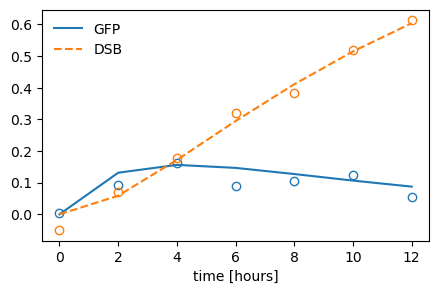

  0.000094 seconds (58 allocations: 6.047 KiB)


PyObject <matplotlib.legend.Legend object at 0x7fd109c986a0>

In [225]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))
p_fake = [0.003*60, 0.002*60, 0.006*60]
@time fake_sol = solve(remake(prob1,p = p_fake),Tsit5(),saveat=2);
sol_data = hcat([[fake_sol[i][2]/sum(fake_sol[i]),fake_sol[i][3]/sum(fake_sol[i])] for i in 1:length(fake_sol)]...)';
fake_odedata = sol_data +rand(Normal(0.0,0.02),size(sol_data))

ax.plot(sol.t,fake_odedata[:,1],"C0o",fillstyle="none")
ax.plot(sol.t,fake_odedata[:,2],"C1o",fillstyle="none")

ax.plot(sol.t,sol_data[:,1],"C0-",label="GFP")
ax.plot(sol.t,sol_data[:,2],"C1--",label="DSB")
ax.set_xlabel("time [hours]")
ax.legend(frameon=false)

In [219]:
fitmodel = fit_func(fake_odedata, prob1)

DynamicPPL.Model{var"#495#496",(:data, :prob1),(),(),Tuple{Array{Float64,2},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(dna_model),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem}},Tuple{}}(:fit_func, var"#495#496"(), (data = [0.010379973438749017 -0.022141537340169624; 0.13520264349526095 0.055715969113836764; … ; 0.10150151158367533 0.5184242833333496; 0.09068991090221422 0.61944164244642], prob1 = ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 12.0)
u0: [1.0, 0.0, 0.0]), NamedTuple())

In [220]:
@time chain = mapreduce(c -> sample(fitmodel, NUTS(.65),1000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/E/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
Sampling:   5%|██▏                                      |  ETA: 0:00:18┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:343
Sampling:  28%|███████████▋                             |  ETA: 0:00:06┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:343
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/E/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
Sampling:  16%|██████▋                                  |  ETA: 0:00:03┌ Warning: dt <= dtmin. Aborting. Th

 51.531517 seconds (64.26 M allocations: 3.532 GiB, 4.94% gc time)


Chains MCMC chain (1000×16×3 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = alpha, beta, rho, sigma
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

       alpha    0.2934    0.1480     0.0027    0.0055   625.9026    1.0026
        beta    0.1389    0.0190     0.0003    0.0007   575.7204    1.0045
         rho    0.3343    0.0433     0.0008    0.0017   591.0918    1.0062
       sigma    0.0212    0.0050     0.0001    0.0002   572.7650    1.0068

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64 

In [221]:
@df chain cornerplot([:alpha :beta :rho :sigma],compact=true)

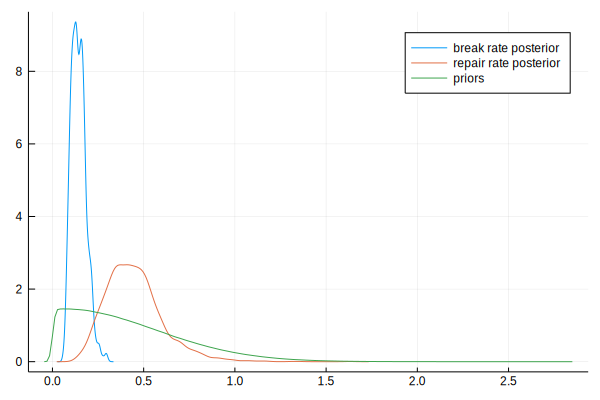

In [188]:
#@df chain density(:alpha)
@df chain density(:beta, label = "break rate posterior")
@df chain density!(:rho,label = "repair rate posterior")
@df chain density!(rand(truncated(Normal(p0[2],0.5),0,Inf),10e7),label="priors")

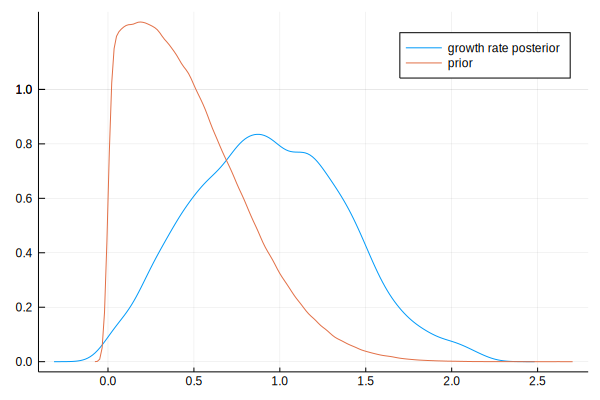

In [248]:
#@df chain density(:alpha)
@df chain density(:alpha,label = "growth rate posterior")
@df chain density!(rand(truncated(Normal(p0[1],0.5),0,Inf),10^6),label="prior")

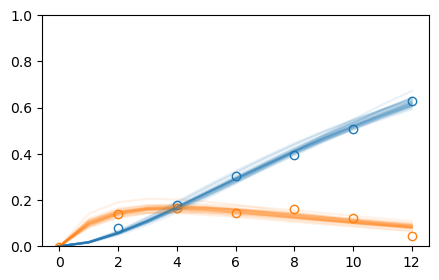

(0, 1)

In [176]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

ax.plot(mol_times,fake_odedata[:,2],"C0o",fillstyle="none")
ax.plot(mol_times,fake_odedata[:,1],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,12.0),p)
    sol = solve(prob_rep,Tsit5(),saveat=1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t ,gfp_rep ./bf_rep,"C0-",alpha=0.1)
    ax.plot(sol.t ,dsb_rep ./bf_rep,"C1-",alpha=0.1)
end

ax.set_ylim([0,1])

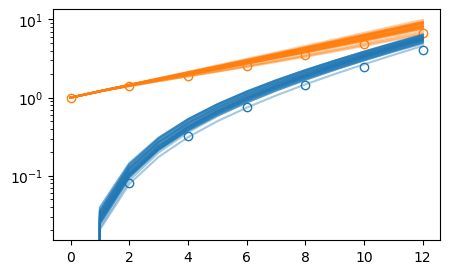

In [247]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

ax.plot(mol_times,[fake_sol.u[i][3] for i in 1:length(mol_times)],"C0o",fillstyle="none")
ax.plot(mol_times,[sum(fake_sol.u[i]) for i in 1:length(mol_times)],"C1o",fillstyle="none")
#ax.plot(mol_times,fake_sol.u[:,1],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,12.0),[0.2,p[2],p[3]])
    sol = solve(prob_rep,Tsit5(),saveat=1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t ,gfp_rep,"C0-",alpha=0.4)
    ax.semilogy(sol.t ,bf_rep,"C1-",alpha=0.4)
end

#ax.set_ylim([0,1])

# Apply to real data

In [256]:
mol_df = CSV.read("./../../experimental_data/processed_data/DSB_df.txt", DataFrame);
mol_times = mol_df[(mol_df.defect .== "NR").&(mol_df.nuclease .== "SpCas9"),:time]
gfp = mol_df[(mol_df.defect .== "NR").&(mol_df.nuclease .== "SpCas9"),:gfp]
dsb = mol_df[(mol_df.defect .== "NR").&(mol_df.nuclease .== "SpCas9"),:dsb]
mol_odedata = hcat(dsb,gfp) ./100.;

In [257]:
fitmodel = fit_func(mol_odedata, prob1)
@time chain = mapreduce(c -> sample(fitmodel, NUTS(.65),1000), chainscat, 1:3)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/E/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/E/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/E/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
Sampling:   5%|█▉                                       |  ETA: 0:00:05┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
Sampling:  10%|████▏                                    |  ETA: 0:00:10┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
Sampling: 10

 18.634242 seconds (37.51 M allocations: 2.177 GiB, 3.99% gc time)


Chains MCMC chain (1000×16×3 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = alpha, beta, rho, sigma
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

       alpha    0.9564    0.4665     0.0085    0.0201   546.1702    1.0065
        beta    0.1448    0.0393     0.0007    0.0017   509.3611    1.0059
         rho    0.4465    0.1611     0.0029    0.0057   662.6629    1.0030
       sigma    0.0464    0.0085     0.0002    0.0003   537.3497    1.0081

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64 

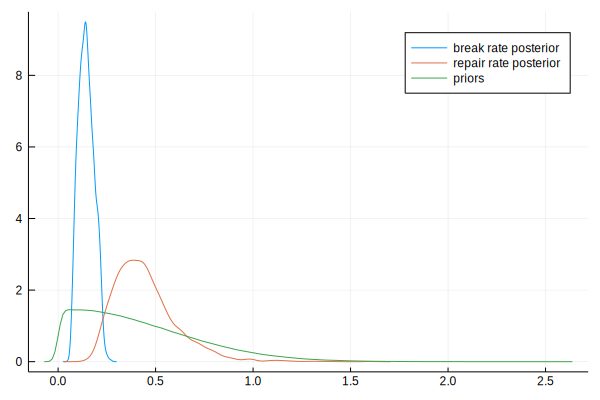

In [260]:
#@df chain density(:alpha)
@df chain density(:beta, label = "break rate posterior")
@df chain density!(:rho,label = "repair rate posterior")
@df chain density!(rand(truncated(Normal(p0[2],0.5),0,Inf),10^6),label="priors")

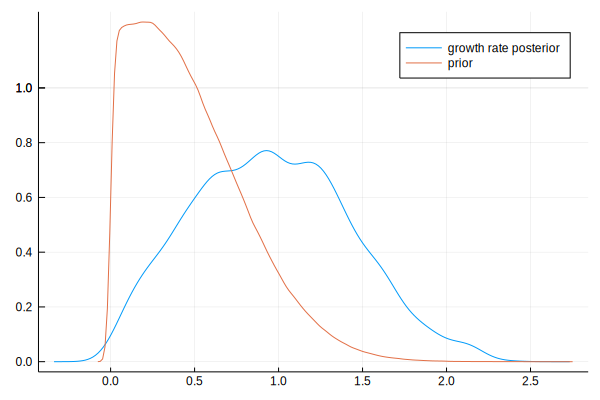

In [261]:
#@df chain density(:alpha)
@df chain density(:alpha,label = "growth rate posterior")
@df chain density!(rand(truncated(Normal(p0[1],0.5),0,Inf),10^6),label="prior")

## look at posterior prediction distribution

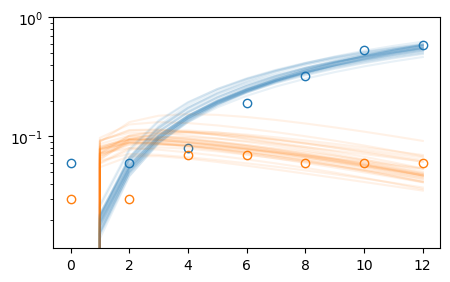

(0.011524344802266644, 1)

In [264]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

ax.plot(mol_times,mol_odedata[:,2],"C0o",fillstyle="none")
ax.plot(mol_times,mol_odedata[:,1],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,12.0),p)
    sol = solve(prob_rep,Tsit5(),saveat=1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t ,gfp_rep ./bf_rep,"C0-",alpha=0.1)
    ax.semilogy(sol.t ,dsb_rep ./bf_rep,"C1-",alpha=0.1)
end

ax.set_ylim([0,1])

In [265]:
micro_df = CSV.read("./../../experimental_data/processed_data/avg_data_one_cell.csv", DataFrame);
experiments = unique(micro_df.experiment)
#df = micro_df[micro_df.experiment .== experiments[1],:].time;
bf = micro_df[(micro_df.defect .== "NR").&(micro_df.nuclease .== "SpCas9"),:bf]
gfp = micro_df[(micro_df.defect .== "NR").&(micro_df.nuclease .== "SpCas9"),:gfp]
micro_times =  micro_df[(micro_df.defect .== "NR").&(micro_df.nuclease .== "SpCas9"),:time]/60.
micro_odedata = hcat(bf,gfp);

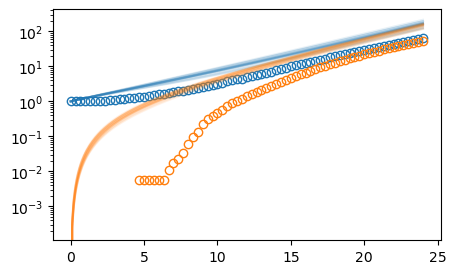

In [273]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

ax.plot(micro_times,micro_odedata[:,1],"C0o",fillstyle="none")
ax.plot(micro_times,micro_odedata[:,2],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:20
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,24.0),[0.23,p[2],p[3]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t ,bf_rep,"C0-",alpha=0.1)
    ax.semilogy(sol.t ,gfp_rep,"C1-",alpha=0.1)
end

#ax.set_ylim([0,1])

In [271]:
fits_df = CSV.read("./output/fits_summary.csv", DataFrame);
fits_df

9×9 DataFrame
 Row │ Column1  Unnamed: 0  experiment       defect  nuclease  alpha_populatio ⋯
     │ Int64    Int64       String           String  String    Float64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       0           0  NR-SpCas9        NR      SpCas9          0.0038528 ⋯
   2 │       1           1  CTG-Cpf1         CTG     Cpf1            0.0038701
   3 │       2           2  CGG-Cpf1         CGG     Cpf1            0.0035746
   4 │       3           3  NoGuideRNA       none    none            0.0040199
   5 │       4           4  GAA-SpCas9-comb  GAA     SpCas9          0.0018229 ⋯
   6 │       5           5  GAA - Cpf1       GAA      Cpf1           0.0037836
   7 │       6           6  CTG-SpCas9-comb  CTG     SpCas9          0.0024802
   8 │       7           7  CGG-SpCas9       CGG     SpCas9          0.0038710
   9 │       8           8  NR-Cpf1-comb     NR      Cpf1            0.0041035 ⋯
                                                               4 columns omitted

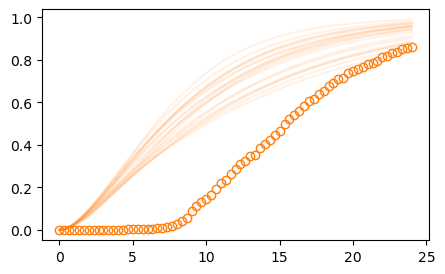

In [278]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

#ax.plot(micro_times,,"C0o",fillstyle="none")
ax.plot(micro_times,micro_odedata[:,2] ./ micro_odedata[:,1],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:20
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,24.0),[0.23,p[2],p[3]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    #ax.plot(sol.t ,,"C0-",alpha=0.1)
    ax.plot(sol.t,gfp_rep ./ bf_rep,"C1-",alpha=0.1)
end
